# Explorative analysis of Vendavo data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

In [2]:
os.getcwd()

'/home/citizends/BOSC-DC/notebooks'

#### Load data 
* Add CSMpT (clean sales margin per ton) based on invoiced volume
* Classify CSMpT in 5 categories (negative, very low [lower then 50], low [lower then 100], medium [lower then 200] and high >200)

In [3]:
#fn = "../../data/BOSC/VendavoData.xlsx"
fn = "../data/raw/VendavoData_AFO.csv"
#df = pd.read_excel(fn,"data")
df = pd.read_csv(fn,sep=';',encoding='iso-8859-1')
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('(', '').str.replace(')', '').str.replace('unnamed:','col').str.replace('.','').str.replace('-','')
int64cols = df.select_dtypes(include=['int64']).columns.values.tolist()
df[int64cols] = df[int64cols].astype(str)
datecols = ['Createdon','Createdon1','ScheddeldateOR','Pricingdate','BillingdateSOItm','DocumentDateSO','Goodsissue']
for c in datecols:
    df[c] = pd.to_datetime(df[c],format='%d.%m.%Y')
df['SchedDelYear'] = df['ScheddeldateOR'].dt.year
df['SchedDelYM'] = df['ScheddeldateOR'].apply(lambda x: x + pd.offsets.MonthBegin(0))

df['timetodelivery'] = df['ScheddeldateOR'] - df['Createdon1']
df['timetodelivery'] = df['timetodelivery'].dt.days

df.sort_values(['CustomerHierlegal_D','GradeclusterMat_D', 'ScheddeldateOR'], inplace=True)
df['timebetweenorders'] = df['ScheddeldateOR'].diff()
mask = df['CustomerHierlegal_D']+df['GradeclusterMat_D'] != df['CustomerHierlegal_D'].shift(1)+df['GradeclusterMat_D'].shift(1)
df['timebetweenorders'][mask] = np.nan
df['timebetweenorders'] = df['timebetweenorders'].dt.days

qtycols = ['Orderquantity','Confirmedqty','Invoicedvolume']
for c in qtycols:
    df[c] = df[c].str.replace('KG','').str.replace(' ','').str.strip().astype(float)
df['CSM'] = df['CSM'].str.replace('EUR','').str.replace(' ','').str.strip().astype(float)
    
def marginclassifier(CSMpT):
    if CSMpT < 0:
        c = 'neg'
    elif CSMpT < 50:
        c = 'very low'
    elif CSMpT < 100:
        c = 'low'
    elif CSMpT < 200:
        c = "med"
    else:
        c = "high"
    return c
df['CSMpT']=df['CSM']*1000.0/df['Invoicedvolume']
df['lowmargin'] = df['CSMpT'].apply(lambda x: marginclassifier(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
print ('The raw data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))

The raw data has 48557 Rows and 54 columns


* Remove order items below 20kT
* Remove Grade clusters starting with 'CLB' (Borouge)

In [5]:
df = df[df['Invoicedvolume']>19999]
print ('The data has {} Rows and {} columns after removing invoiced volumes below 20000kg'.format(df.shape[0],df.shape[1]))
df = df[~df['GradeclusterMat'].str.contains("CLB")]
print ('The data has {} Rows and {} columns after removing invoiced volumes below 20000kg and Borouge Grade Clusters'.format(df.shape[0],df.shape[1]))

The data has 41357 Rows and 54 columns after removing invoiced volumes below 20000kg
The data has 41357 Rows and 54 columns after removing invoiced volumes below 20000kg and Borouge Grade Clusters


#### Run basic statistics on numerical variables

In [6]:
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType']

summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df

,count,mean,std,min,25%,50%,75%,max,missing,unique,DataType
Orderquantity,40028.0,28841.949011,32743.037496,16240.000000,23375.00000,24800.000000,26000.000000,1.188000e+06,1329,1985,float64
Confirmedqty,40049.0,28840.244301,32745.253301,11000.000000,23375.00000,24800.000000,26000.000000,1.188000e+06,1308,1978,float64
Invoicedvolume,41357.0,28632.113886,32465.482201,20000.000000,23375.00000,24580.000000,25540.000000,1.188000e+06,0,2286,float64
CSM,41357.0,7811.669875,8853.163713,-21416.000000,4744.00000,6787.000000,8994.000000,4.199020e+05,0,13156,float64
SchedDelYear,41357.0,2016.914259,0.808540,2015.000000,2016.00000,2017.000000,2018.000000,2.018000e+03,0,4,int64
timetodelivery,41357.0,20.643228,13.169269,-328.000000,12.00000,18.000000,27.000000,3.250000e+02,0,144,int64
timebetweenorders,39361.0,21.032240,52.915380,0.000000,1.00000,5.000000,21.000000,9.470000e+02,1996,3821,float64
CSMpT,41357.0,280.754030,145.115941,-442.060606,189.81775,271.445783,351.511111,2.091919e+03,0,29865,float64


#### Run basic statistics on categorical variables

In [7]:
col_names = list(types_df.index) #Get all col names
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index: #Find the indices of columns in Categorical columns
    if col_names[i] in list(set(list(df.select_dtypes(exclude=[np.number]).columns))):
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat.sort_values(by=['unique'])

,missing,unique,DataType
ProdQualMatSal,0,1,object
ProducttypeMat,0,2,object
OrderTypeSO,0,2,object
SalesChn0sold,0,2,object
CustSegmCGroup,0,4,object
lowmargin,0,5,object
Incoterms,0,7,object
BU/IndClZCMIR,0,7,object
ProductgroupMat_D,0,10,object
ProductgroupMat,0,10,object


In [8]:
df['PriceAgreementType'].unique()

array(['MonthlyFreeNegotiation', '#', 'AssetLoading', 'SpotDeal',
       'LinkedToMonomer', 'LinkedToPolymer', 'QuarterlyFreeNegotiation',
       'HedgedPricing', 'DistributorSpecialPricing', 'Project',
       'DistributorTemporaryPricing', 'LinkedPricing'], dtype=object)

#### Invoiced volumes by MA for 2018

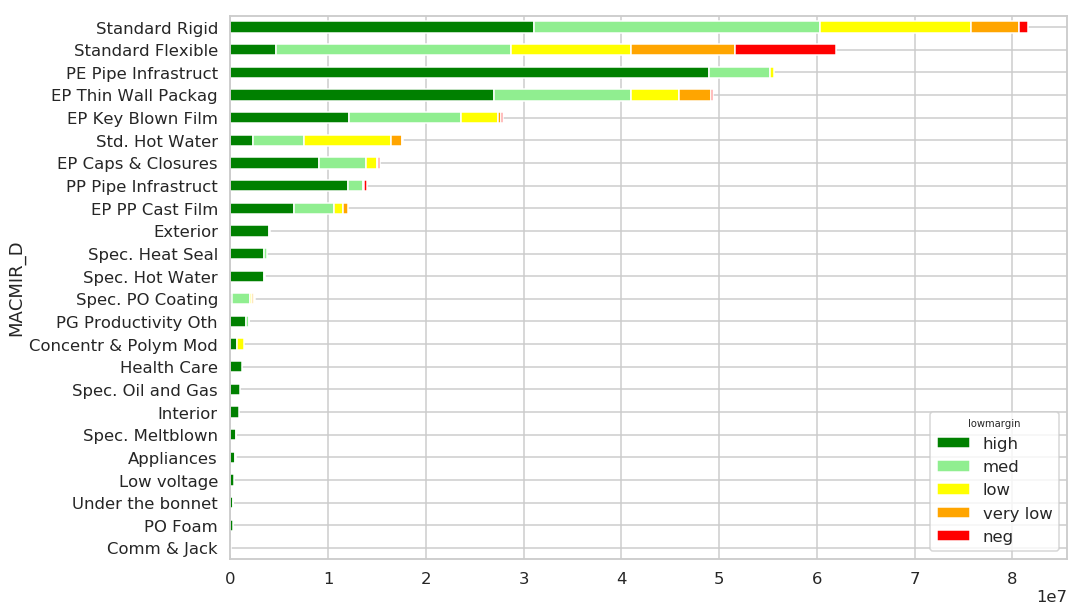

In [9]:
dfMA = df[df['SchedDelYear']==2018].pivot_table(index='MACMIR_D', columns='lowmargin', values='Invoicedvolume',aggfunc=np.sum,margins=True)
def plotPivotTable(df,figsize=(15,10),top=None):
    df.drop('All',inplace=True)
    df.sort_values(by=['All'], ascending=True,inplace=True)
    df.drop(['All'],axis=1,inplace=True)
    color_labels = ['neg','very low','low','med','high'][::-1]
    rgb_dict = {'neg':(1.0,0,0),'very low':(1.0,165.0/255,0),'low':(1.0,1.0,0),'med':(144.0/255,238.0/255,144.0/255),'high':(0,128.0/255,0)}
    rgb_values = [rgb_dict[x] for x in color_labels]
    if top==None:
        df.loc[:,color_labels].plot(kind='barh',stacked=True,figsize=figsize,color=rgb_values)
    else:
        df.tail(top).loc[:,color_labels].plot(kind='barh',stacked=True,figsize=figsize,color=rgb_values)
    return
plotPivotTable(dfMA)

In [10]:
dfMA[['neg','very low','low','med','high'][::-1]].sort_values(by=['neg'], ascending=False)

lowmargin,high,med,low,very low,neg
MACMIR_D,,,,,
Standard Flexible,4626967.0,24074998.0,12315104.0,10624180.0,10349945.0
Standard Rigid,31006777.0,29328635.0,15446277.0,4847117.0,916460.0
EP Caps & Closures,9007530.0,4851485.0,1091975.0,99000.0,297000.0
PP Pipe Infrastruct,12014005.0,1534800.0,93500.0,46750.0,280500.0
EP Key Blown Film,12085670.0,11448135.0,3848610.0,281480.0,173155.0
EP Thin Wall Packag,26996486.0,13991220.0,4930600.0,3250125.0,145000.0
Std. Hot Water,2267650.0,5254525.0,8894000.0,1113200.0,140225.0
Spec. PO Coating,143650.0,1883375.0,196890.0,172450.0,71960.0
Comm & Jack,99000.0,NaN,NaN,NaN,NaN


#### Invoiced volumes by End Use for 2018

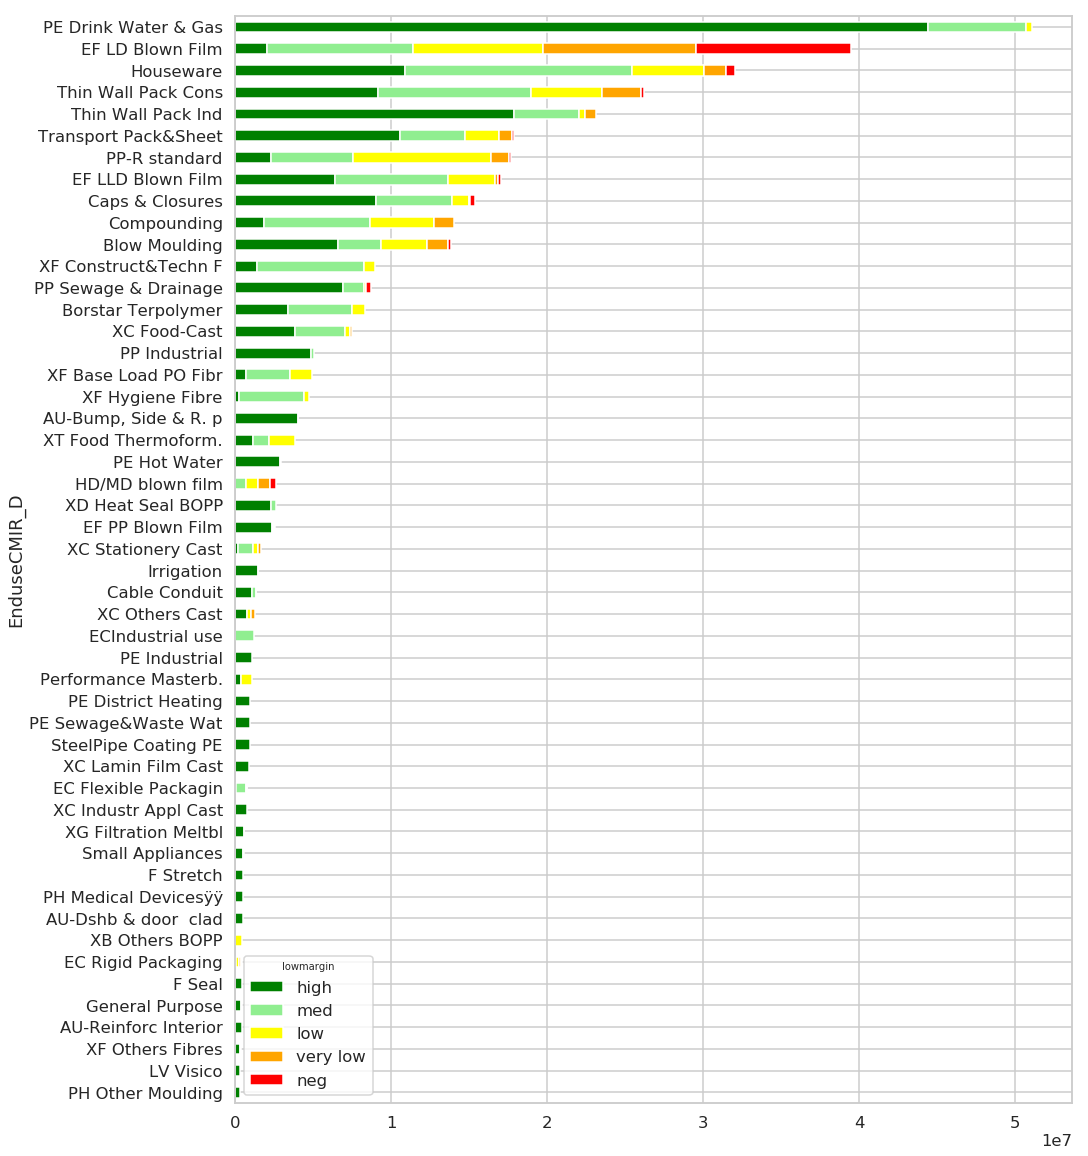

In [11]:
dfMA = df[df['SchedDelYear']==2018].pivot_table(index='EnduseCMIR_D', columns='lowmargin', values='Invoicedvolume',aggfunc=np.sum,margins=True)
plotPivotTable(dfMA,(15,20),50)

In [12]:
df['PT_EU'] = df['EnduseCMIR_D'] + "-" + df['ProducttypeMat']

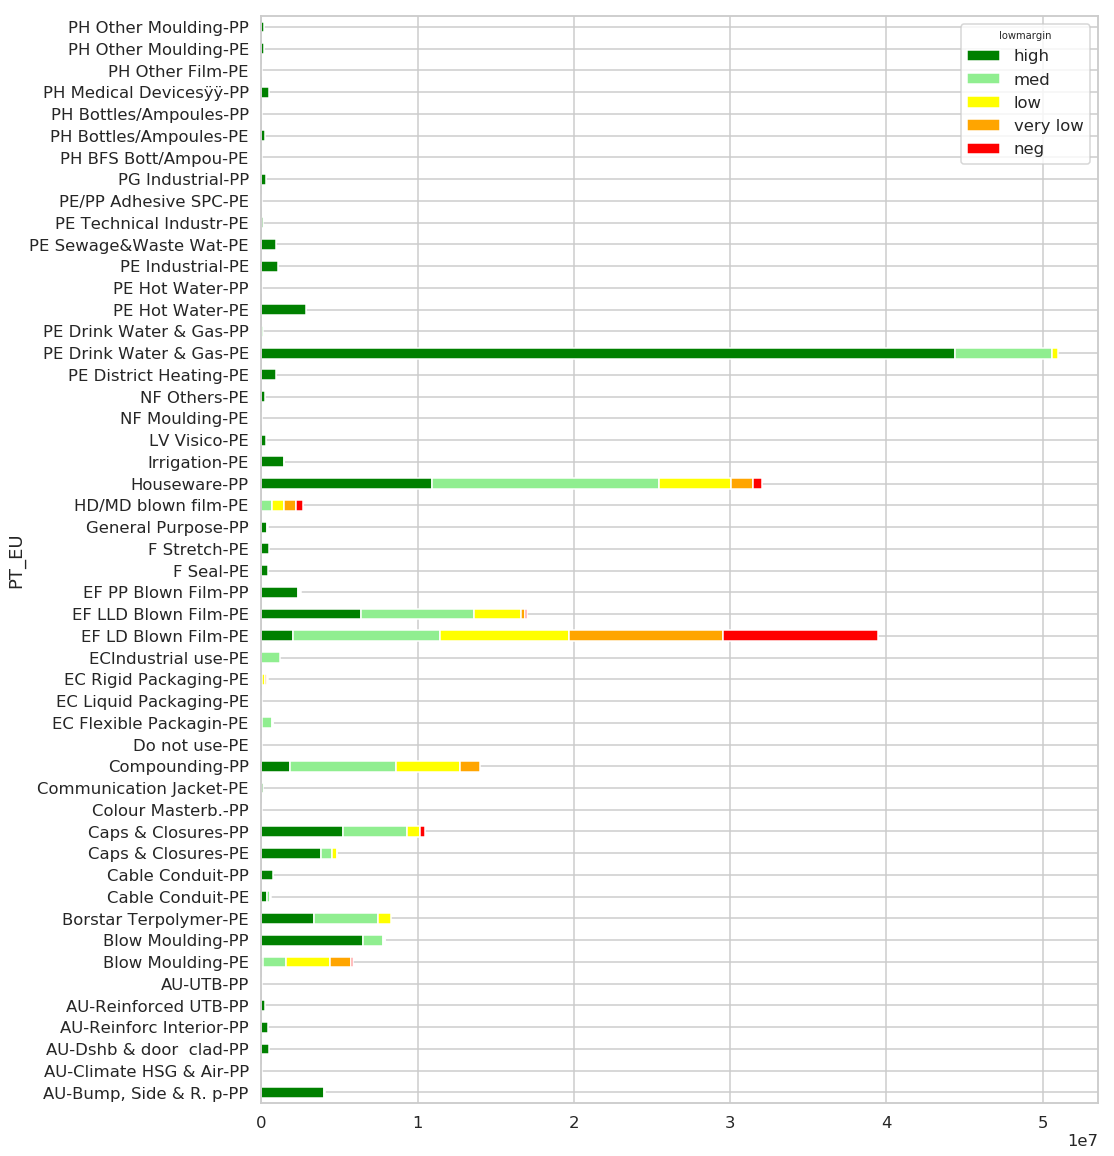

In [13]:
dfMA = df[df['SchedDelYear']==2018].pivot_table(index='PT_EU', columns='lowmargin', values='Invoicedvolume',aggfunc=np.sum,margins=True)
def plotPivotTable1(df,figsize=(15,10),top=None):
    df.drop('All',inplace=True)
    #df.sort_values(by=['All'], ascending=True,inplace=True)
    df.drop(['All'],axis=1,inplace=True)
    color_labels = ['neg','very low','low','med','high'][::-1]
    rgb_dict = {'neg':(1.0,0,0),'very low':(1.0,165.0/255,0),'low':(1.0,1.0,0),'med':(144.0/255,238.0/255,144.0/255),'high':(0,128.0/255,0)}
    rgb_values = [rgb_dict[x] for x in color_labels]
    if top==None:
        df.loc[:,color_labels].plot(kind='barh',stacked=True,figsize=figsize,color=rgb_values)
    else:
        df.head(top).loc[:,color_labels].plot(kind='barh',stacked=True,figsize=figsize,color=rgb_values)
    return

plotPivotTable1(dfMA,(15,20),50)

#### Invoiced volume by Product Group for 2018

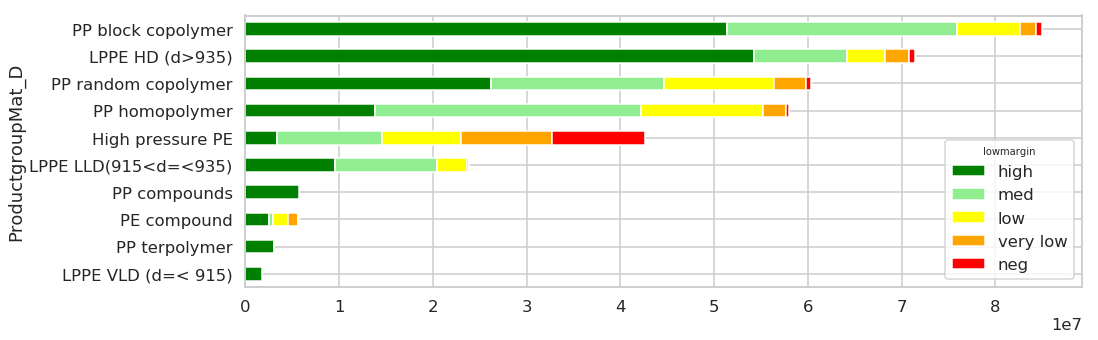

In [14]:
dfMA = df[df['SchedDelYear']==2018].pivot_table(index='ProductgroupMat_D', columns='lowmargin', values='Invoicedvolume',aggfunc=np.sum,margins=True)
plotPivotTable(dfMA,(15,5))

#### Invoiced volume by Grade Cluster for 2018 (top 40)

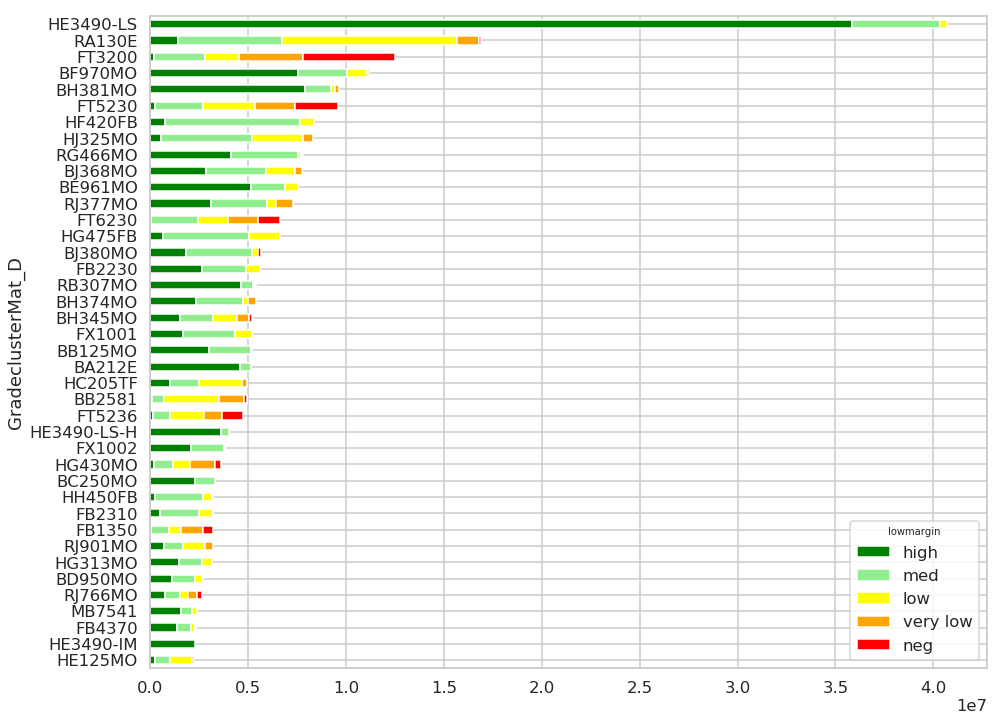

In [15]:

dfMA = df[df['SchedDelYear']==2018].pivot_table(index='GradeclusterMat_D', columns='lowmargin', values='Invoicedvolume',aggfunc=np.sum,margins=True)
plotPivotTable(dfMA,(15,12),40)

#### Invoiced volume by Plant for 2018

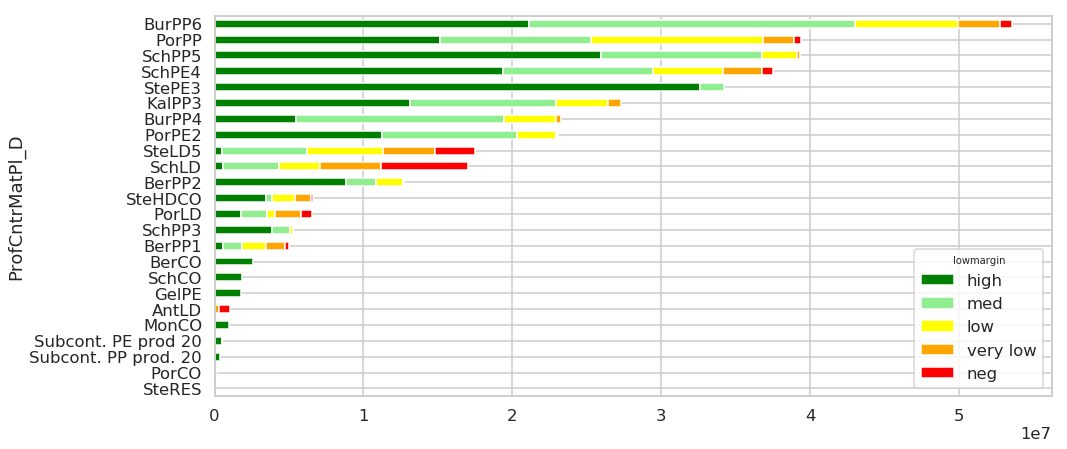

In [16]:
dfMA = df[df['SchedDelYear']==2018].pivot_table(index='ProfCntrMatPl_D', columns='lowmargin', values='Invoicedvolume',aggfunc=np.sum,margins=True)
plotPivotTable(dfMA,(15,7))

#### Number of orderitems by industry cluster and Customer segmentation for 2017

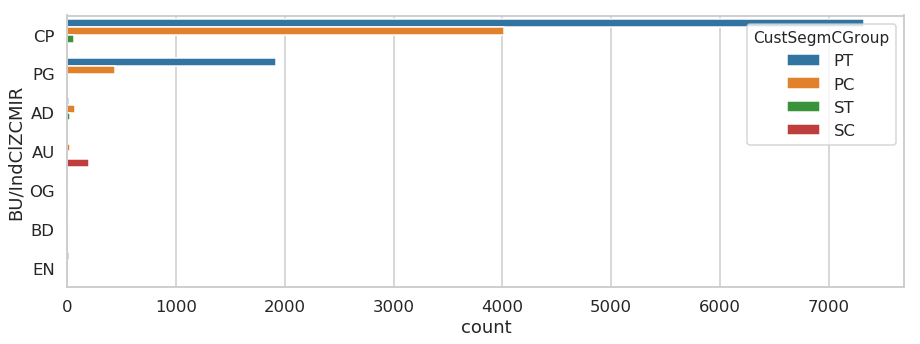

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(y='BU/IndClZCMIR',hue='CustSegmCGroup',data=df[df['SchedDelYear']==2017])
plt.show()

#### Distribution of CSM per ton for 2017

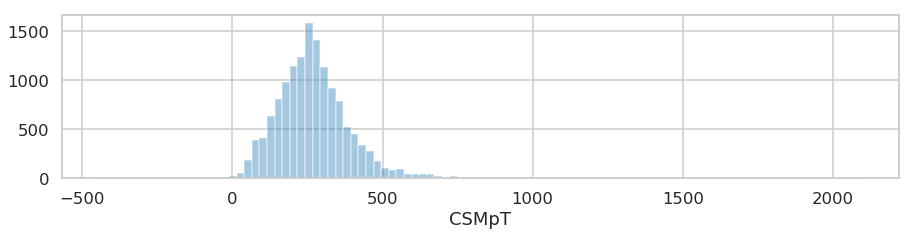

In [18]:
plt.figure(figsize=(15,3))
df1 = df[df['SchedDelYear']==2017]
sns.distplot(df1['CSMpT'].dropna(),bins=100,kde=False)
plt.show()

#### Customers with very low margin orders (< 50)

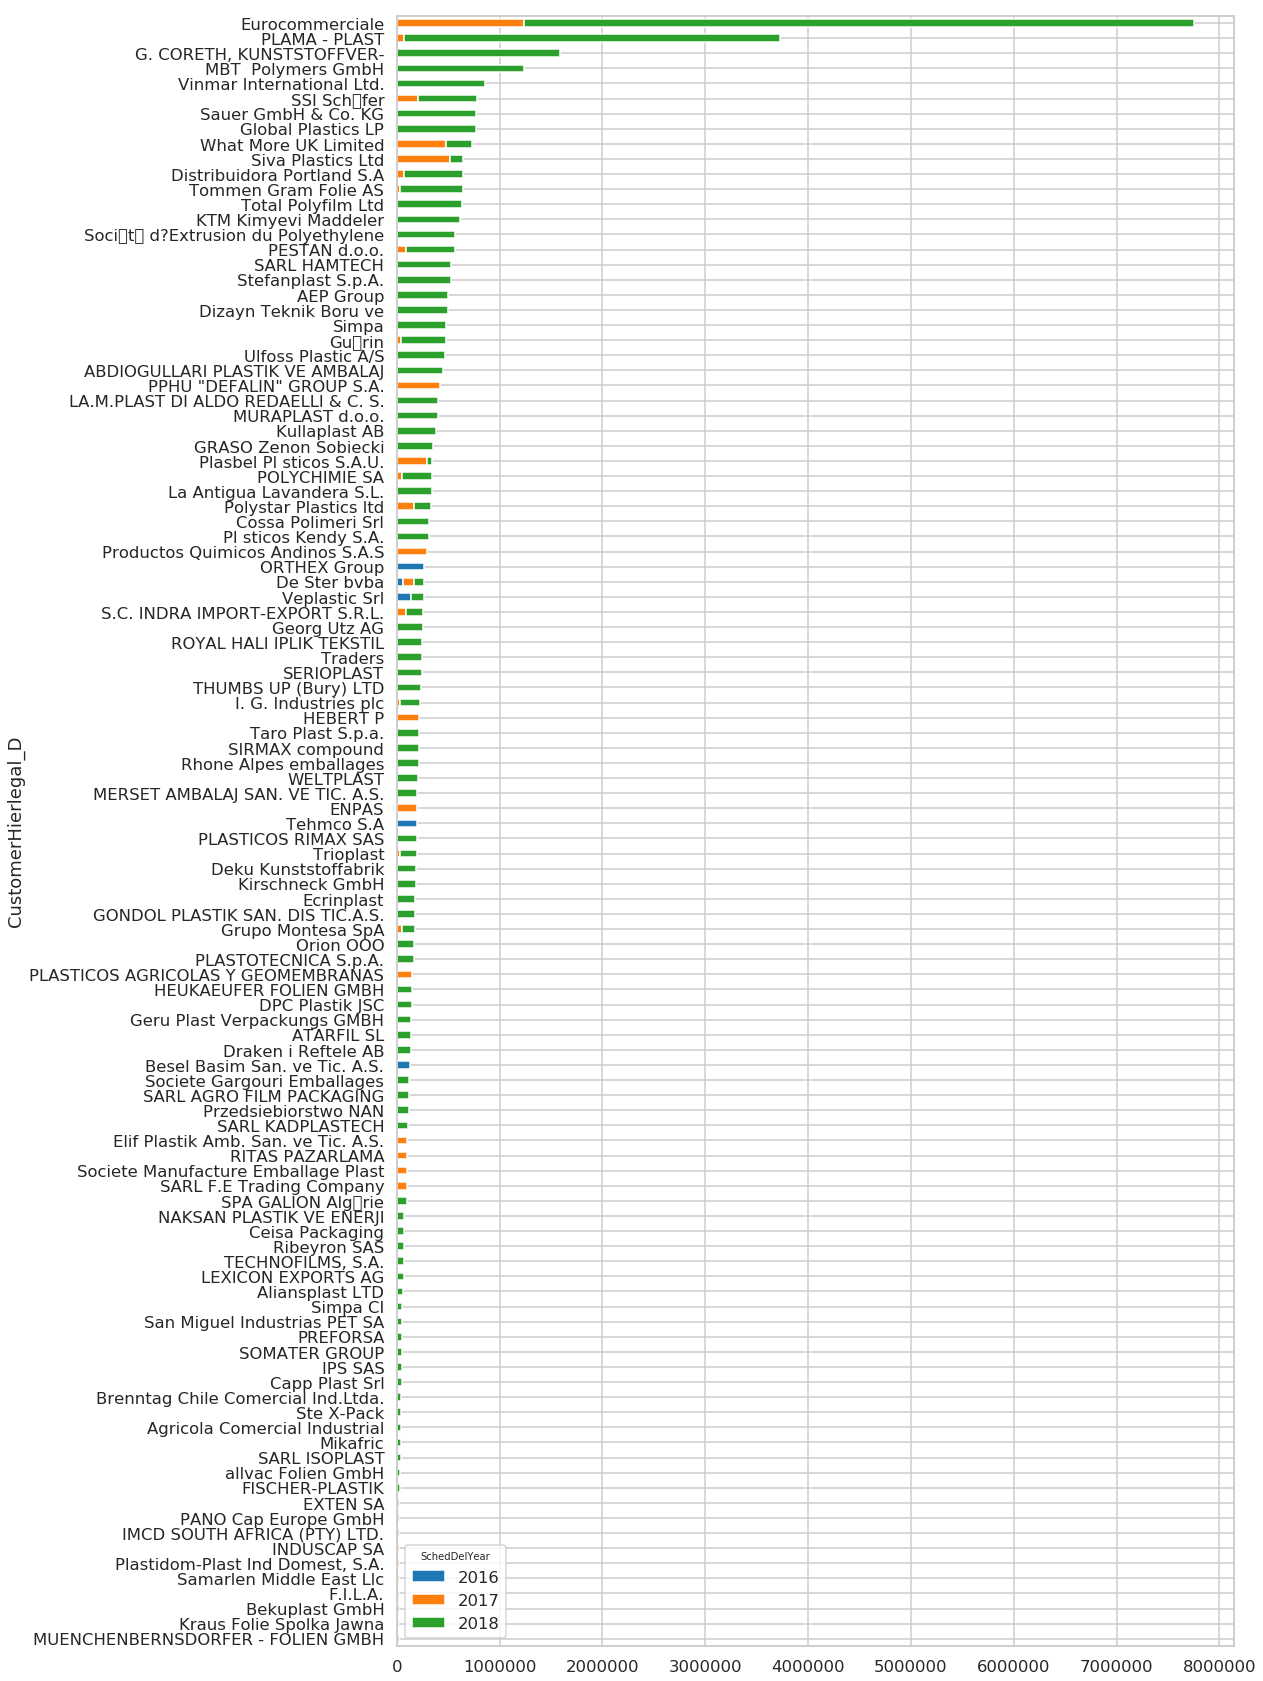

In [19]:
df1 = df[df['CSMpT']<50]
df2 = df1.pivot_table(index='CustomerHierlegal_D', columns='SchedDelYear', values='Invoicedvolume',aggfunc=np.sum,margins=True)
#sns.barplot(x= 'Invoicedvolume', y='CustomerHierlegal_D',hue='SchedDelYear',data=df1[df1['CSMpT']<50], estimator=sum, ci=None)
df2.drop('All',inplace=True)
df2.sort_values(by=['All'], ascending=True,inplace=True)
df2.drop(['All'],axis=1,inplace=True)
df2.plot(kind='barh',stacked=True,figsize=(15,30))


#### Order pattern and clean sales margin by Customer

In [20]:
aggcol = 'CustomerHierlegal_D'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l = df.loc[mask,aggcol].unique().tolist()
l.sort()
l

def plottimeline(df,aggcol,aggvalue):   
    import matplotlib.dates as mdates
    df_GH = df[df[aggcol]==aggvalue].groupby(['ScheddeldateOR','lowmargin'],as_index=False).agg({'Invoicedvolume':'sum','CSMpT':'mean'})
    print(df_GH.shape[0], "order items")
    #df['ScheddeldateOR'] = pd.to_datetime(df['ScheddeldateOR'],format='%Y-%m-%d')
    df_GH.set_index('ScheddeldateOR',inplace=True)
    #print(df.index)
    #df_GH = df_GH['2012-01-01':'2017-07-01']
    color_labels = df_GH['lowmargin'].unique().tolist()
    color_labels.sort()
    rgb_dict = {'neg':(1.0,0,0),'very low':(1.0,165.0/255,0),'low':(1.0,1.0,0),'med':(144.0/255,238.0/255,144.0/255),'high':(0,128.0/255,0)}
    rgb_values = [rgb_dict[x] for x in color_labels]
    #rgb_values = sns.color_palette("Set1", len(color_labels))
    color_map = dict(zip(color_labels, rgb_values))
    fig = plt.figure(figsize=(18,5))
    ax = plt.subplot(111)
    ax2 = ax.twinx()
    ax2.plot(df_GH.index,df_GH['CSMpT'])
    for k in color_map:
        ax.bar(df_GH[df_GH['lowmargin']==k].index,df_GH.loc[df_GH['lowmargin']==k,'Invoicedvolume'],width=2.0,color=color_map[k],alpha=0.8,edgecolor='black', linewidth=1.0,label=k)
    ax.xaxis_date()
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.legend()
    plt.show()
    #print(df_GH.head())
    
def plottimelineDF(aggval):
    #plottimeline(df[df['SchedDelYear']==2018],aggcol,aggval)
    plottimeline(df[mask].sort_values(by=['lowmargin'], ascending=False),aggcol,aggval)

interact(plottimelineDF, aggval = l)

interactive(children=(Dropdown(description='aggval', options=('A+C Plastic Kunststoff GmbH', 'A-Kassi Ky', 'AB…

<function __main__.plottimelineDF(aggval)>

In [21]:
mask = df['ScheddeldateOR']>'2018-01-01'
dfc = df[df['CustomerHierlegal_D']=='PLAMA - PLAST']
dfc = dfc[mask]
dfc.groupby(['GradeclusterMat_D','lowmargin'],as_index=False).agg({'Invoicedvolume':'sum','CSMpT':'mean'})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,GradeclusterMat_D,lowmargin,Invoicedvolume,CSMpT
0,BA110CF,med,23375.0,160.171123
1,FA6224,neg,186725.0,-23.298701
2,FA6224,very low,163625.0,35.159664
3,FB2230,low,46750.0,84.299465
4,FB2230,med,46750.0,168.000000
5,FT3200,low,210375.0,88.014260
6,FT3200,med,770000.0,117.571139
7,FT3200,neg,815375.0,-29.601996
8,FT3200,very low,1237500.0,18.312178
9,FT5230,low,105875.0,86.704813


In [22]:
aggcol1 = 'BU/IndClZCMIR'
mask = df['ScheddeldateOR']>'2018-06-01'
from ipywidgets import interact
l1 = df.loc[mask,aggcol1].unique().tolist()
l1.sort()
def plottimelineDF1(aggval):
    plottimeline(df[mask].sort_values(by=['lowmargin'],ascending=False),aggcol1,aggval)
interact(plottimelineDF1, aggval = l1)

interactive(children=(Dropdown(description='aggval', options=('AD', 'AU', 'BD', 'CP', 'EN', 'OG', 'PG'), value…

<function __main__.plottimelineDF1(aggval)>

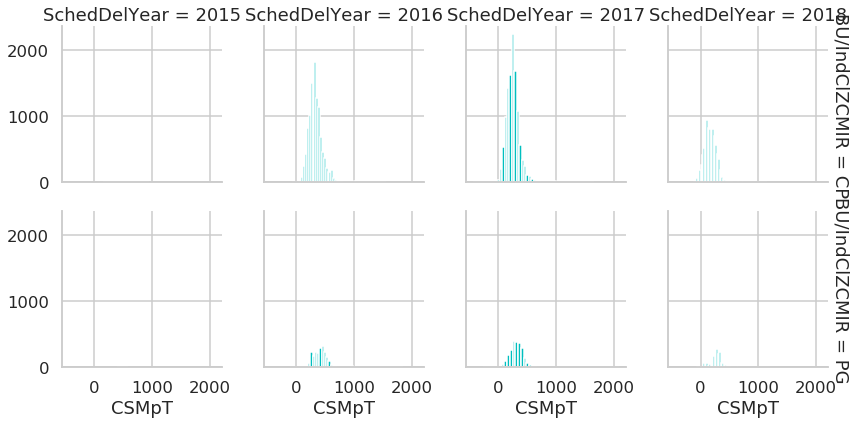

In [23]:
filter = df['BU/IndClZCMIR'].isin(["CP","PG"])
g = sns.FacetGrid(df[filter], col="SchedDelYear", row="BU/IndClZCMIR", margin_titles=True)
g.map(plt.hist, "CSMpT", bins=50,color='c')

In [24]:
aggcol2 = 'MACMIR_D'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l = df.loc[mask,aggcol2].unique().tolist()
l.sort()
def plottimelineDF2(aggval):
    plottimeline(df[mask],aggcol2,aggval)
interact(plottimelineDF2, aggval = l)

interactive(children=(Dropdown(description='aggval', options=('Appliances', 'Comm & Jack', 'Concentr & Polym M…

<function __main__.plottimelineDF2(aggval)>

In [25]:
aggcol3 = 'ProductgroupMat_D'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l3 = df.loc[mask,aggcol3].unique().tolist()
l3.sort()
def plottimelineDF3(aggval):
    plottimeline(df[mask],aggcol3,aggval)
interact(plottimelineDF3, aggval = l3)

interactive(children=(Dropdown(description='aggval', options=('High pressure PE', 'LPPE HD (d>935)', 'LPPE LLD…

<function __main__.plottimelineDF3(aggval)>

In [26]:
aggcol4 = 'EnduseCMIR_D'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l4 = df.loc[mask,aggcol4].unique().tolist()
l4.sort()
def plottimelineDF4(aggval):
    plottimeline(df[mask],aggcol4,aggval)
interact(plottimelineDF4, aggval = l4)

interactive(children=(Dropdown(description='aggval', options=('AU-Bump, Side & R. p', 'AU-Climate HSG & Air', …

<function __main__.plottimelineDF4(aggval)>

In [27]:
aggcol4 = 'PT_EU'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l4 = df.loc[mask,aggcol4].unique().tolist()
l4.sort()
def plottimelineDF4(aggval):
    plottimeline(df[mask],aggcol4,aggval)
interact(plottimelineDF4, aggval = l4)

interactive(children=(Dropdown(description='aggval', options=('AU-Bump, Side & R. p-PP', 'AU-Climate HSG & Air…

<function __main__.plottimelineDF4(aggval)>

In [28]:
aggcol5 = 'GradeclusterMat_D'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l5 = df.loc[mask,aggcol5].unique().tolist()
l5.sort()
def plottimelineDF5(aggval):
    plottimeline(df[mask],aggcol5,aggval)
interact(plottimelineDF5, aggval = l5)

interactive(children=(Dropdown(description='aggval', options=('0201', '0201FX', '0203', '0230', '8201', '8210'…

<function __main__.plottimelineDF5(aggval)>

#### Regularity Analysis
* Minimum number of order items in 1 year = 12 for each customer/grade combination
* Small variance on time between order items for each customer/grade combination
* Small variance on order volume for each customer/grade combination
* Small variance of order time before delivery for each customer/grade combination
* This regular pattern is applicable for the majority of the grades for a customer

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


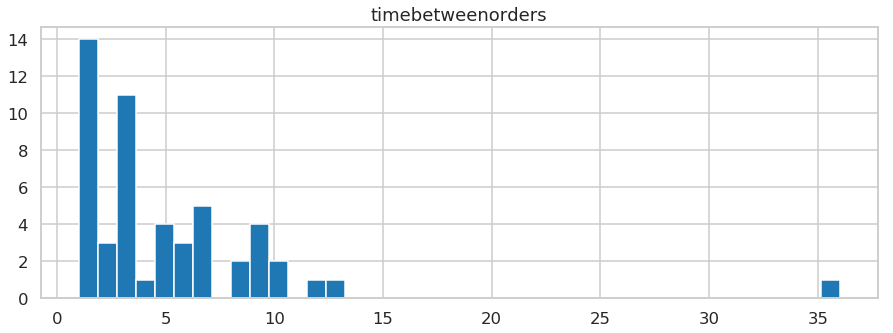

In [29]:
filter1 = df['CustomerHierlegal_D'] == "Eurocommerciale"
filter2 = df['GradeclusterMat_D'] == "FT3200"
filter3 = df['ScheddeldateOR']>'2018-01-01'
mask1 = filter1 & filter2 & filter3
dfst = df[mask1]
dfst['timebetweenorders'] = dfst[['ScheddeldateOR']].sort_values(by='ScheddeldateOR').diff()
dfst['timebetweenorders'] = dfst['timebetweenorders'].dt.days
#dfst.plot(x='ScheddeldateOR', y = 'timebetweenorders', kind='bar',figsize=(15,5))
dfst.groupby('ScheddeldateOR').sum()[1:].hist(column='timebetweenorders',bins=40, figsize=(15,5),label='timebetweenorders')
grouped = dfst.groupby('ScheddeldateOR')
#print(grouped['timebetweenorders'].sum()[1:])
#dfst

,Orderquantity,Confirmedqty,Invoicedvolume,CSM,SchedDelYear,timetodelivery,timebetweenorders,CSMpT
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,36752.358491,36752.358491,36580.754717,401.452830,3046.037736,18.339623,4.962264,19.725619
std,24966.630260,24966.630260,24951.940467,2385.538035,2190.058991,18.873000,5.459509,100.260105
min,23375.000000,23375.000000,22000.000000,-2676.000000,2018.000000,1.000000,0.000000,-104.128342
25%,23375.000000,23375.000000,23375.000000,-881.000000,2018.000000,7.000000,1.000000,-35.304911
50%,27500.000000,27500.000000,26175.000000,-140.000000,2018.000000,12.000000,3.000000,-5.989305
75%,46750.000000,46750.000000,46750.000000,1682.000000,4036.000000,18.000000,7.000000,71.957219
max,162250.000000,162250.000000,162250.000000,9337.000000,14126.000000,101.000000,36.000000,402.085561


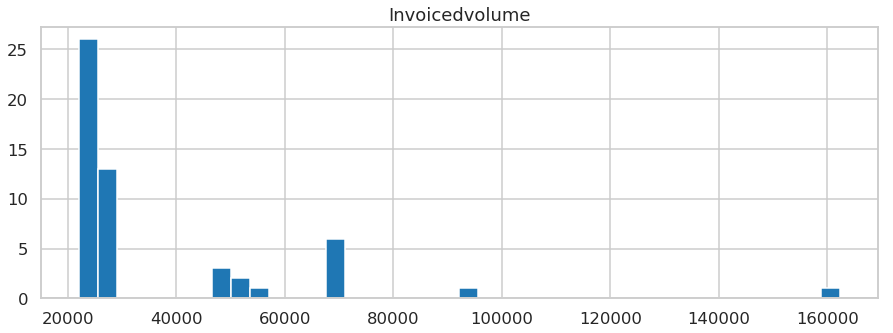

In [30]:
dfst.groupby('ScheddeldateOR').sum().hist(column='Invoicedvolume',bins=40, figsize=(15,5))
dfst.groupby('ScheddeldateOR').sum().describe()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73f5a2b668>]],
      dtype=object)

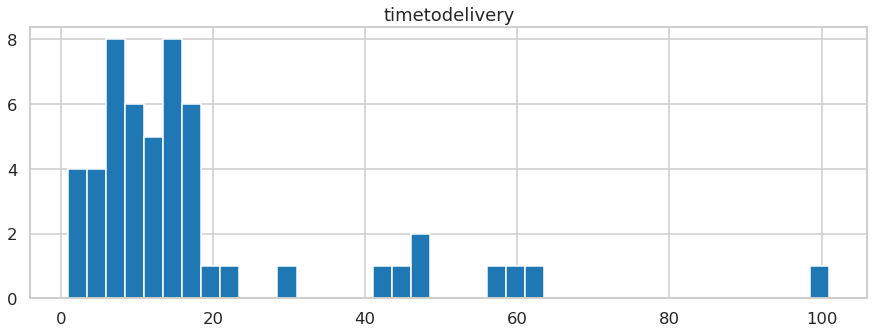

In [31]:
dfst['timetodelivery'] = dfst['ScheddeldateOR'] - dfst['Createdon1']
dfst['timetodelivery'] = dfst['timetodelivery'].dt.days
#dfst.plot(x='ScheddeldateOR', y = 'timebetweenorders', kind='bar',figsize=(15,5))
dfst.groupby('ScheddeldateOR').sum()[1:].hist(column='timetodelivery',bins=40, figsize=(15,5),label='timebetweenorders')

In [32]:
aggcol = 'CustomerHierlegal_D'
mask = df['ScheddeldateOR']>'2018-01-01'
from ipywidgets import interact
l = df.loc[mask,aggcol].unique().tolist()
l.sort()
l

def plottimelinemonthly(df,aggcol,aggvalue):   
    import matplotlib.dates as mdates
    df_GH = df[df[aggcol]==aggvalue].groupby(['SchedDelYM','lowmargin'],as_index=False).agg({'Invoicedvolume':'sum','CSMpT':'mean'})
    print(df_GH.shape[0], "order items")
    #df['ScheddeldateOR'] = pd.to_datetime(df['ScheddeldateOR'],format='%Y-%m-%d')
    df_GH.set_index('SchedDelYM',inplace=True)
    #print(df.index)
    #df_GH = df_GH['2012-01-01':'2017-07-01']
    color_labels = df_GH['lowmargin'].unique().tolist()
    color_labels.sort()
    rgb_dict = {'neg':(1.0,0,0),'very low':(1.0,165.0/255,0),'low':(1.0,1.0,0),'med':(144.0/255,238.0/255,144.0/255),'high':(0,128.0/255,0)}
    rgb_values = [rgb_dict[x] for x in color_labels]
    #rgb_values = sns.color_palette("Set1", len(color_labels))
    color_map = dict(zip(color_labels, rgb_values))
    fig = plt.figure(figsize=(18,5))
    ax = plt.subplot(111)
    ax2 = ax.twinx()
    ax2.plot(df_GH.index,df_GH['CSMpT'])
    for k in color_map:
        ax.bar(df_GH[df_GH['lowmargin']==k].index,df_GH.loc[df_GH['lowmargin']==k,'Invoicedvolume'],width=2.0,color=color_map[k],alpha=0.8,edgecolor='black', linewidth=1.0,label=k)
    ax.xaxis_date()
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.legend()
    plt.show()
    #print(df_GH.head())
    
def plottimelinemonthlyDF(aggval):
    #plottimeline(df[df['SchedDelYear']==2018],aggcol,aggval)
    plottimelinemonthly(df[mask].sort_values(by=['lowmargin'], ascending=False),aggcol,aggval)

interact(plottimelinemonthlyDF, aggval = l)

interactive(children=(Dropdown(description='aggval', options=('A+C Plastic Kunststoff GmbH', 'A-Kassi Ky', 'AB…

<function __main__.plottimelinemonthlyDF(aggval)>

In [33]:
import nbformat as nbf
from IPython.core.display import HTML
from IPython.display import display
from ipywidgets import interact, interactive,fixed
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import ipywidgets
import IPython
from IPython.display import clear_output

# Provide the path to the yaml file relative to the working directory
display(HTML('''<style>
    .widget-label { min-width: 20ex !important; }
    .widget-text { min-width: 60ex !important; }
</style>'''))

#Toggle Code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();

 } else {
 $('div.input').show();

 }
 code_show = !code_show
} 
//$( document ).ready(code_toggle);//commenting code disabling by default
</script>
<form action = "javascript:code_toggle()"><input type="submit" value="Toggle Raw Code"></form>''')